https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data

# Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset:

In [2]:
#import dataset

df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# Data Exploration:

After we imported the dataset, we have to look at the total number of rows in the dataset and analyze the number of missing values.



In [3]:
# Number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 11162 rows.


In [4]:
# Finding missing values for each column
missing_values = df.isnull().sum()
missing_values

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

No missing values found!

In [5]:
def visualize_numerical_histograms(dataframe, num_columns):
    """
    Visualize histograms for numerical columns in the DataFrame.

    Parameters:
    dataframe (DataFrame): The input DataFrame containing the data.
    num_columns (list): A list of numerical column names.

    Returns:
    None
    """

    fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

    counter = 0
    for num_column in num_columns:
        trace_x = counter // 3
        trace_y = counter % 3

        axs[trace_x, trace_y].hist(dataframe[num_column])

        axs[trace_x, trace_y].set_title(num_column)

        counter += 1

    plt.show()


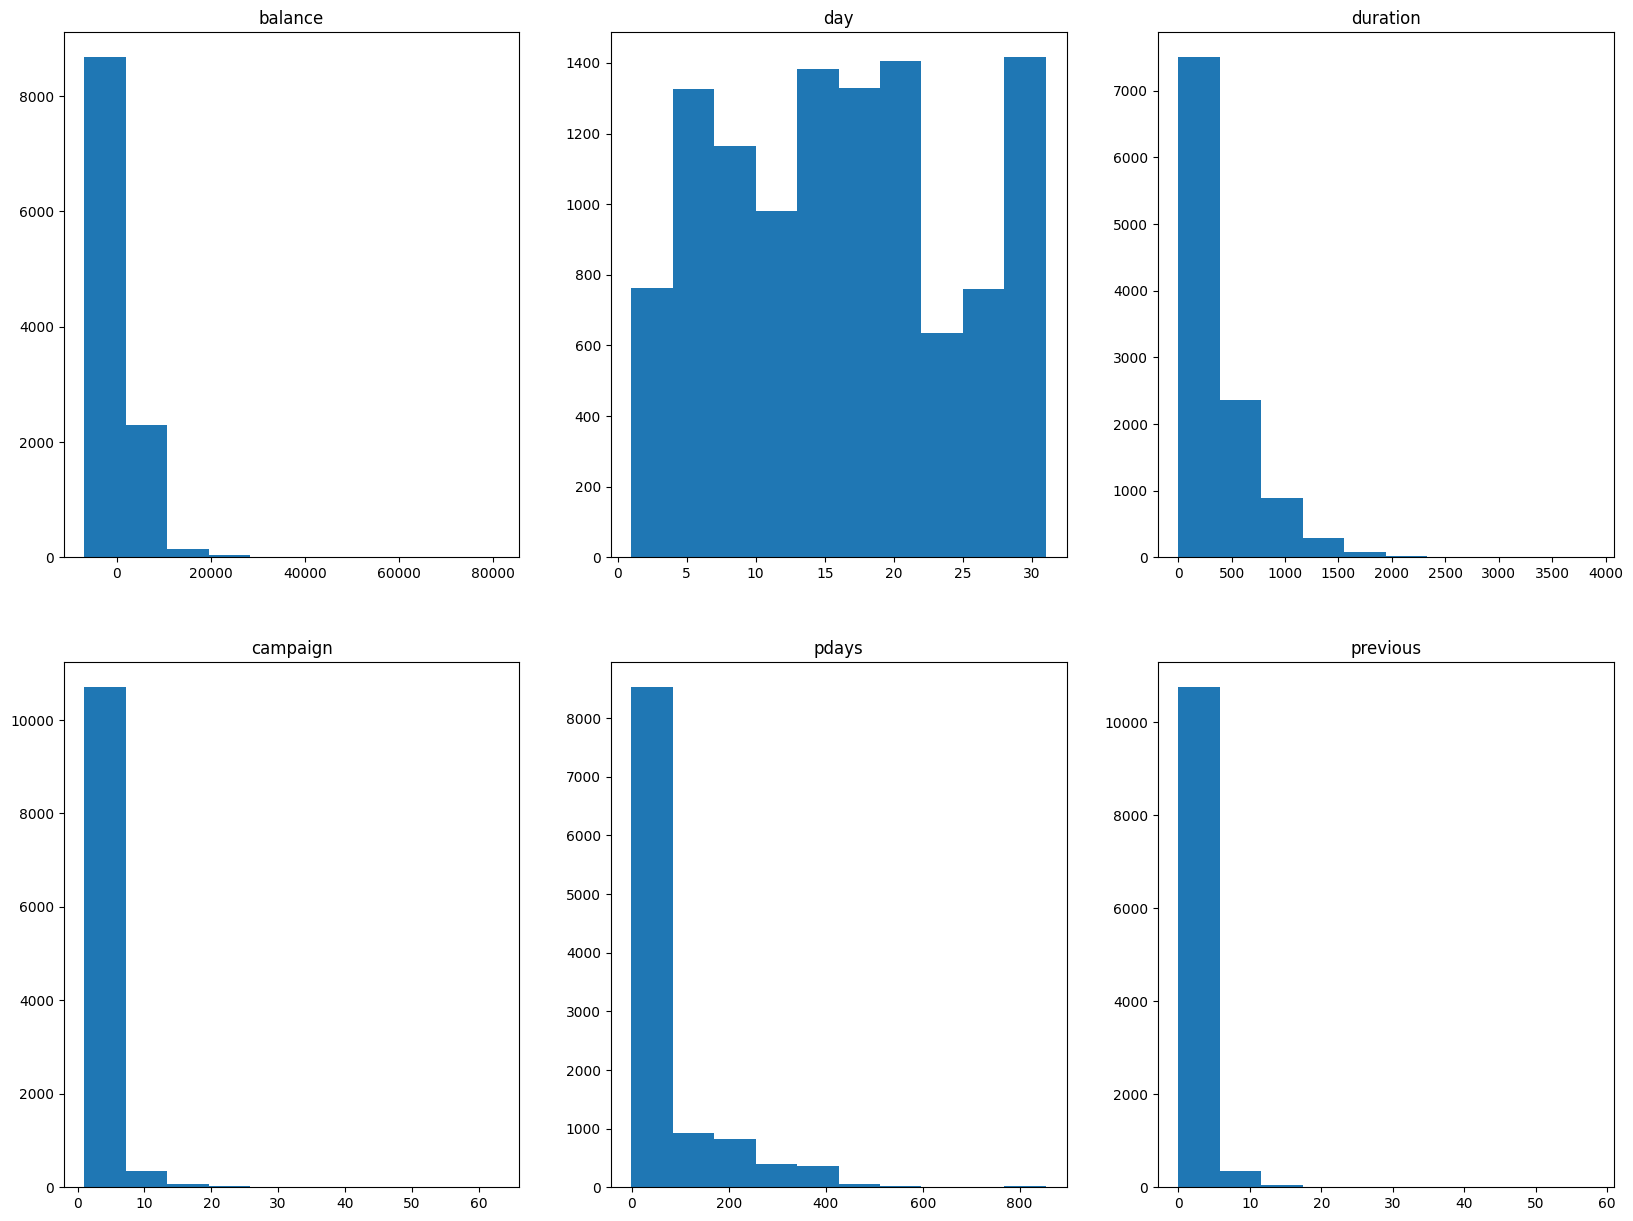

In [6]:
visualize_numerical_histograms(df, ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:



In [7]:
df[['pdays', 'campaign', 'previous']].describe()


,pdays,campaign,previous
count,11162.000000,11162.000000,11162.000000
mean,51.330407,2.508421,0.832557
std,108.758282,2.722077,2.292007
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,20.750000,3.000000,1.000000
max,854.000000,63.000000,58.000000


'pdays' exhibits a wide range of values with a mean of 51.33 and a considerable standard deviation of 108.76, indicating extensive variability. Conversely, 'campaign' and 'previous' demonstrate comparatively lower means (2.51 and 0.83, respectively) and standard deviations, suggesting less variability.

In [8]:
def explore_data(data):
    """
    Explores the dataset by displaying major moments, correlation matrix, and basic statistics.

    Parameters:
        data (DataFrame): Input dataset.

    Returns:
        None
    """
    # Display major moments
    moments = pd.DataFrame({
        'Mean': data.mean(),
        'Median': data.median(),
        'Standard Deviation': data.std(),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    })
    print("Major Moments:")
    print(moments)
    print("\n")

# Example usage:
explore_data(df)

Major Moments:
                 Mean  Median  Standard Deviation  Skewness    Kurtosis
age         41.231948    39.0           11.913369  0.862780    0.621540
balance   1528.538524   550.0         3225.413326  8.224619  126.861303
day         15.658036    15.0            8.420740  0.111330   -1.061324
duration   371.993818   255.0          347.128386  2.143695    7.301282
campaign     2.508421     2.0            2.722077  5.545578   57.389771
pdays       51.330407    -1.0          108.758282  2.449986    6.838359
previous     0.832557     0.0            2.292007  7.335298  106.197826




The feature 'age' exhibits a mean of approximately 41.23 years, with a moderate standard deviation of 11.91, suggesting a relatively dispersed distribution. Conversely, 'balance' displays a substantially higher mean of 1528.54, accompanied by a significantly larger standard deviation of 3225.41, indicating considerable variability in account balances. The feature 'duration' showcases an average call duration of 371.99 seconds, with a moderate spread indicated by the standard deviation of 347.13. 

Let's see how 'deposit' column value varies depending on other categorical columns' values:



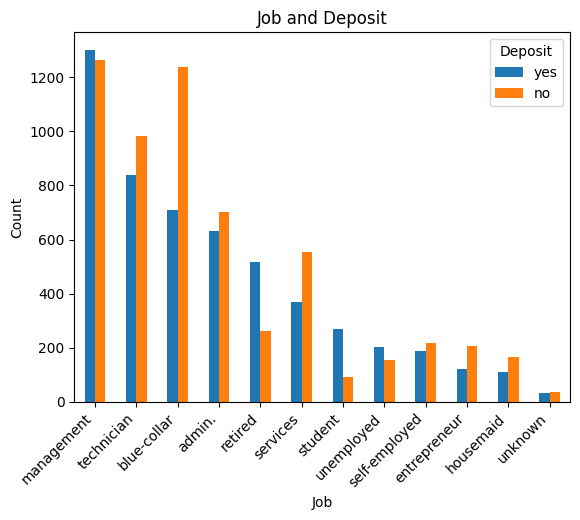

In [9]:
def visualize_job_deposit(df):
    """
    Visualize the distribution of job categories among deposit subscribers and non-subscribers.

    Parameters:
    df (DataFrame): The input DataFrame containing job and deposit information.

    Returns:
    None
    """
    j_df = pd.DataFrame()
    j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
    j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()
    j_df.plot.bar(title='Job and Deposit')
    plt.xlabel('Job')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Deposit', loc='upper right')
    plt.show()
    
visualize_job_deposit(df)

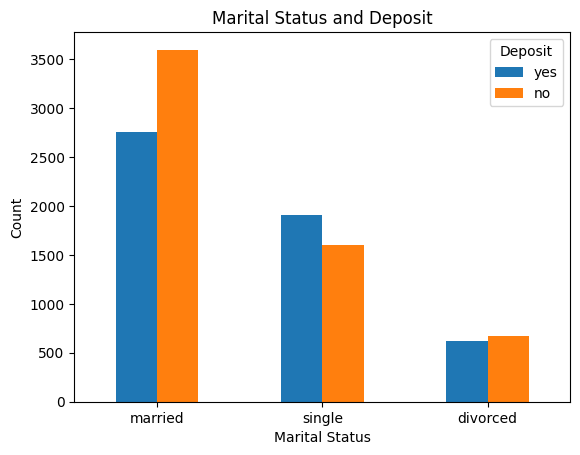

In [10]:
def visualize_marital_deposit(df):
    """
    Visualize the distribution of marital status among deposit subscribers and non-subscribers.

    Parameters:
    df (DataFrame): The input DataFrame containing marital status and deposit information.

    Returns:
    None
    """
    j_df = pd.DataFrame()
    j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
    j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()
    j_df.plot.bar(title='Marital Status and Deposit')
    plt.xlabel('Marital Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title='Deposit', loc='upper right')
    plt.show()

visualize_marital_deposit(df)

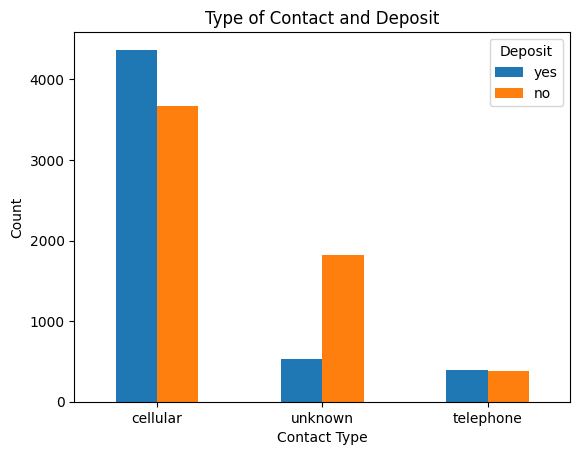

In [11]:
def visualize_contact_deposit(df):
    """
    Visualize the distribution of contact types among deposit subscribers and non-subscribers.

    Parameters:
    df (DataFrame): The input DataFrame containing contact type and deposit information.

    Returns:
    None
    """
    j_df = pd.DataFrame()
    j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
    j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()
    j_df.plot.bar(title='Type of Contact and Deposit')
    plt.xlabel('Contact Type')
    plt.ylabel('Count')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title='Deposit', loc='upper right')
    plt.show()

visualize_contact_deposit(df)

Regarding the diagrams we can tell that according to our dataset:

<li>Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.</li>
<li>Married customers are less likely to subscribe for term deposit.</li>
<li>Customers with 'cellular' type of contact are less likely to subscribe for term deposit.</li>

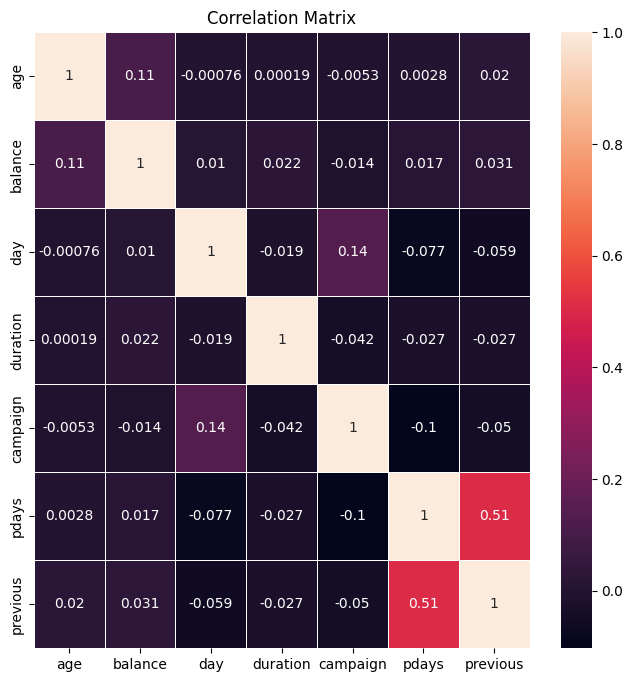

In [12]:
def visualize_correlation_matrix(df):
    """
    Visualize the correlation matrix of the DataFrame using a heatmap.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(df.corr(), annot=True, linewidths=0.5, ax=ax)
    plt.title("Correlation Matrix")
    plt.show()

visualize_correlation_matrix(df)

The correlation matrix heatmap provides insights into the relationships between different variables in the dataset. One notable observation is the moderate positive correlation between "days" and "previous" contacts (r = 0.51). This suggests that there is a moderate linear relationship between the number of days since the last contact and the number of previous contacts.







# Data Preprocessing:

In [13]:
cont_features = []
cat_features = []

for c in df.columns:
    if df[c].dtype == 'int64':
        cont_features += [c]
    else:
        cat_features += [c]

In [14]:
df[cat_features].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
deposit       2
dtype: int64

In [15]:
# applying one-hot encoder on categorical features
OH_encoder = OneHotEncoder(handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[cat_features]))

# adding back indexes
OH_cols.index = df.index

# keeping just the continuous features
df_cont = df.drop(cat_features, axis=1)

# adding back encoded categoricals to continous features
df_OH = pd.concat([df_cont, OH_cols], axis=1)

Next, let's plot our two continous features.



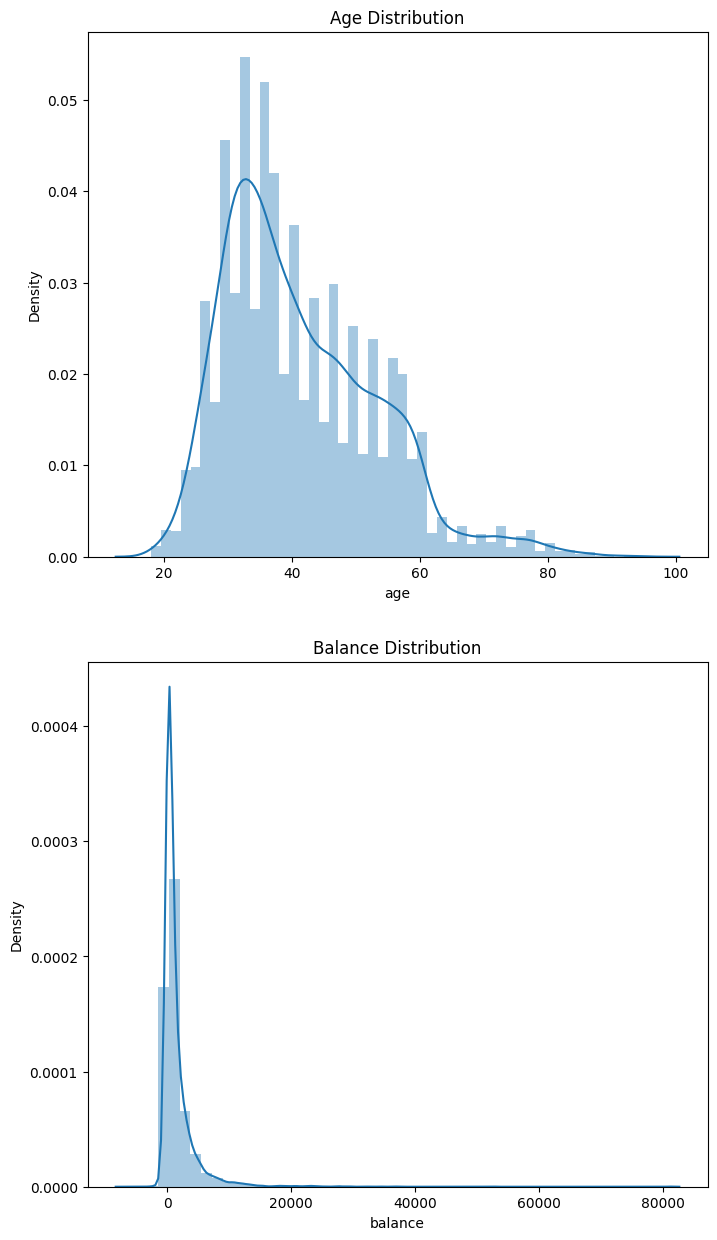

In [16]:
def visualize_distribution(dataframe):
    """
    Visualize the distribution of selected columns in a DataFrame.

    Parameters:
    dataframe (DataFrame): The input DataFrame containing the data.

    Returns:
    None
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,15))
    sns.distplot(dataframe['age'], ax=ax1)
    sns.distplot(dataframe['balance'], ax=ax2)
    ax1.set_title('Age Distribution')
    ax2.set_title('Balance Distribution')
    plt.show()
    
visualize_distribution(df_OH)

Our distributions are right-skewed (tail on the right) and the features are not scaled. A log transformation will reduce skewness and StandardScaler will standardize the features by removing the mean and scaling to unit variance. These two important steps will allow our model to perform better.



# K-Means Clustering:

We will run KMeans 10 times, each time with a different value of 'k'. We will store the inertia each time around and plot for each k in the end. Let's do it first on just our two continous variables.



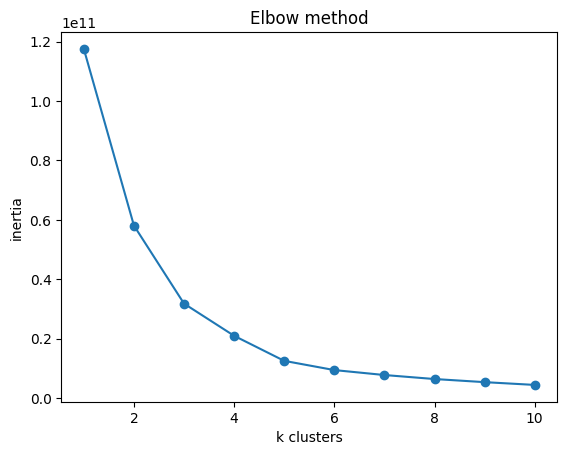

In [17]:
def plot_elbow_method(dataframe):
    """
    Visualize the inertia for different numbers of clusters using the elbow method.

    Parameters:
    dataframe (DataFrame): The input DataFrame containing the data.

    Returns:
    None
    """
    inertia = []

    for n_clusters in range(1,11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=30, max_iter=100)
        clusters = kmeans.fit_predict(df[cont_features])
        inertia.append(kmeans.inertia_)
        
    plt.plot(range(1,11), inertia, marker='o')
    plt.title('Elbow method')
    plt.xlabel('k clusters')
    plt.ylabel('inertia')
    plt.show()



plot_elbow_method(df)

Here, we are looking for the elbow point, after which the inertia gets smaller but by only so much. This is no hard rule for selecting 'k' and in this case anything from 3 to 5 would make sense. Let's choose 5 for now.



In [18]:
def kmeans_clustering(dataframe, num_clusters=5):
    """
    Perform K-means clustering on the dataframe and add cluster labels as a new column.

    Parameters:
    dataframe (DataFrame): The input DataFrame containing the data.
    num_clusters (int): The number of clusters to form.

    Returns:
    None
    """
    kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=30, max_iter=100)
    clusters = kmeans.fit_predict(df[cont_features])
    df['cluster'] = clusters

kmeans_clustering(df)

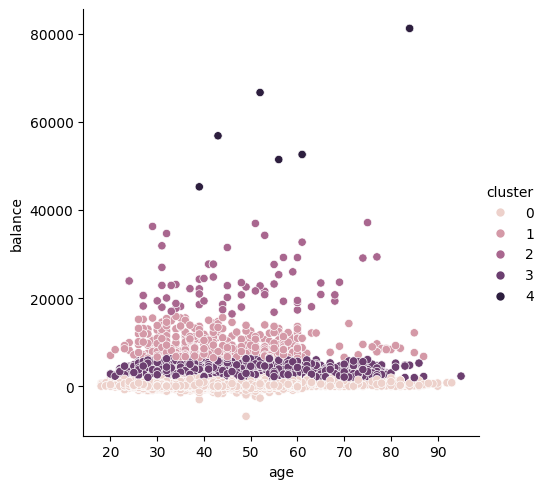

In [19]:
def visualize_cluster_relationship(dataframe):
    """
    Visualize the relationship between two features colored by cluster.

    Parameters:
    dataframe (DataFrame): The input DataFrame containing the data.
    x_feature (str): The name of the feature to be plotted on the x-axis.
    y_feature (str): The name of the feature to be plotted on the y-axis.
    cluster_column (str): The name of the column containing cluster labels.

    Returns:
    None
    """
    sns.relplot(x='age', y='balance', hue='cluster', data=df)
    plt.show()

visualize_cluster_relationship(df)

Here clusters are discernible, indicating distinct segments in the dataset based on age and balance. However, there appears to be some overlap between clusters, suggesting that age and balance alone may not be sufficient to perfectly separate the data into distinct groups. Further analysis or additional features might be necessary to improve clustering accuracy.

# Linear Regression:

In [20]:
df['job'] = df['job'].astype('category').cat.codes
df['marital'] = df['marital'].astype('category').cat.codes
df['education'] = df['education'].astype('category').cat.codes

In [21]:
# Splitting Data
X = df.drop('balance', axis=1)  # Features
y = df['balance']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# One-hot encode categorical variables
categorical_cols = ['default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)

In [23]:
def train_linear_regression(X_train, y_train):
    """
    Train a linear regression model with additional hyperparameters.

    Parameters:
    X_train (DataFrame): The input features for training.
    y_train (Series): The target variable for training.

    Returns:
    model: Trained linear regression model.
    """
    model = LinearRegression(fit_intercept=True, positive=False, copy_X=True, n_jobs=None)
    model.fit(X_train, y_train)
    return model

model = train_linear_regression(X_train_encoded, y_train)

In [34]:
def evaluate_linear_regression(model, X_test_encoded, y_test):
    """
    Evaluate a linear regression model using Mean Squared Error and R-squared Score.

    Parameters:
    model: Trained linear regression model.
    X_test (DataFrame): The input features for testing.
    y_test (Series): The target variable for testing.

    Returns:
    None
    """
    y_pred = model.predict(X_test_encoded[0:2233])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)

evaluate_linear_regression(model, X_test_encoded, y_test)

Mean Squared Error: 14756775.39630033
R-squared Score: -0.16212809886066837


The R-squared score of 0.025 indicates that only about 2.5% of the variance in the balance values can be explained by the model. This suggests that the linear regression model has limited predictive power in explaining the variability in the balance values based on the given features.

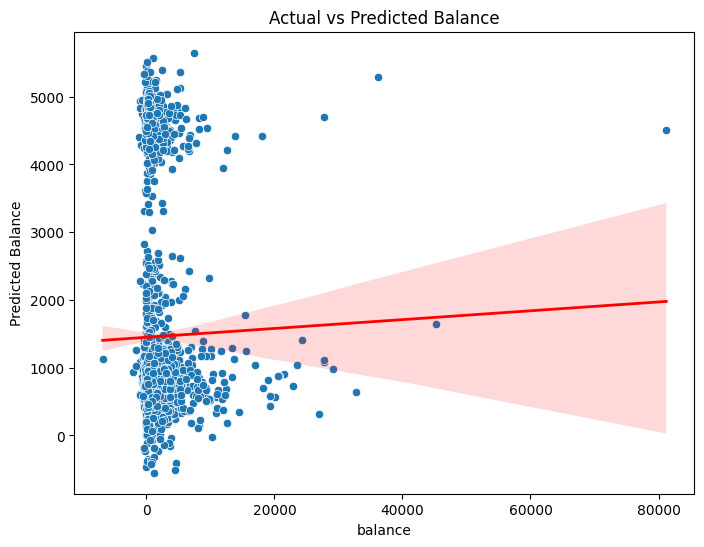

In [36]:
def visualize_actual_vs_predicted(y_test, y_pred):
    """
    Visualize a scatter plot of actual vs predicted balance along with the linear regression line and confidence interval.

    Parameters:
    y_test (Series): The actual balance values.
    y_pred (Series): The predicted balance values.

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual Balance')
    plt.ylabel('Predicted Balance')
    plt.title('Actual vs Predicted Balance')

    # Linear regression line with confidence interval
    sns.regplot(x=y_test, y=y_pred, scatter=False, ci=95, color='r', line_kws={'linewidth': 2})

    plt.show()

y_pred = model.predict(X_test_encoded[0:2233])
visualize_actual_vs_predicted(y_test, y_pred)

The alignment of data points around the regression line indicates a reasonable fit, suggesting that the model captures the underlying relationship between the actual and predicted balance values. However, deviations from the regression line for certain data points might indicate areas where the model performs less optimally, warranting further investigation into potential factors influencing these discrepancies. 